Meshing

In [1]:
import os
import multiprocessing
from posix import truncate
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

is_solid = True ; 

if is_solid:
    part_name = "origami_living_hinge.step"
    meshing_script_name = "Living_hinge_1.geo"
    cgx_script_name = "Living_hinge_1.fbd"
    run_script_name = "run.fbd"
else:
    part_name = "origami_shell.step"
    meshing_script_name = "Living_hinge_1_shell2.geo"
    cgx_script_name = "Living_hinge_1_shell.fbd"
    run_script_name = "run_shell.fbd"

meshing_accuracy = 1000
displacement_magnitude =  -0.200e-1

# Modify the geo file
with open(meshing_script_name , "r") as file:
    lines = file.readlines()

with open(meshing_script_name , "w") as file:
    for line in lines:
        if line.strip().startswith("Merge"):
            file.write(f'Merge "{part_name}";\n')
        elif line.strip().startswith("Mesh.CharacteristicLengthMax"):
            file.write(f"Mesh.CharacteristicLengthMax = {meshing_accuracy};\n")
        else:
            file.write(line) 

# Enable multithreading for ccx
os.environ['OMP_NUM_THREADS'] = str(multiprocessing.cpu_count())
snap = os.listdir(os.curdir)
os.system(f"cgx -b {cgx_script_name}")

on a Darwin machine, nodename Mac.attlocal.net, release 24.5.0, version Darwin Kernel Version 24.5.0: Tue Apr 22 19:54:26 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T8112, machine arm64 
 The HOME was detected:/Users/hugopenichou
parameters:3 arguments:2
GL_MAX_EVAL_ORDER:30, mesh threads:1
 /Users/hugopenichou/.cgx opened

 reading file
 done 

 Living_hinge_1.fbd opened

 reading file
 # sys gmsh part.step -clcurv -3 -o gmsh.inp -order 2
******************************************************************************
*  read ccx input                                   4.4.2002 wi              *
*                                                                            *
*                                                                            *
* -only free-format is supported. fixed format might cause a prg-crash.      *
*                                                                            *
*                                                                            *

0

In [2]:
%matplotlib widget
import dis
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def regroup_faces_C3D10(elements, node_coords):
    faces = []
    for elem in elements:
        if len(elem) < 4:
            continue
        n1, n2, n3, n4 = elem[:4]  # Only use corner nodes

        try:
            # 4 triangular faces of a tetrahedron
            faces.append([node_coords[n1], node_coords[n2], node_coords[n3]])
            faces.append([node_coords[n1], node_coords[n2], node_coords[n4]])
            faces.append([node_coords[n1], node_coords[n3], node_coords[n4]])
            faces.append([node_coords[n2], node_coords[n3], node_coords[n4]])
        except KeyError as e:
            print(f"Warning: Node ID {e} not found. Skipping element.")
    return faces

def regroup_faces_CPS6(elements, node_coords):
    faces = []
    for elem in elements:
        if len(elem) != 6:
            continue  # Skip non-CPS6 elements

        try:
            face = [node_coords[elem[i]] for i in range(6)]
            faces.append(face)
        except KeyError as e:
            print(f"Warning: Node ID {e} not found. Skipping element.")
    return faces

def regroup_faces_S8R(elements, node_coords):
    """
    Build 8-node quadrilateral faces from shell elements (S8R).
    Each face will be represented by its 8 node coordinates.
    """
    faces = []
    for elem in elements:
        if len(elem) != 8:
            continue  # Skip non-S8R elements

        try:
            face = [node_coords[elem[i]] for i in range(8)]
            faces.append(face)
        except KeyError as e:
            print(f"Warning: Node ID {e} not found. Skipping element.")
    return faces

def group_faces(node_coords):
    x = [coord[0] for coord in node_coords.values()]
    y = [coord[1] for coord in node_coords.values()]
    z = [coord[2] for coord in node_coords.values()]

    group1 = {}  # fixed typo
    group2 = {}


    group1_threshold = np.max(z)
    group2_threshold = np.min(z)
    tolerance = 0.000005

    for key , values in node_coords.items():
        if np.abs( values[2] - group1_threshold ) < tolerance:
            group1[key] = values 
        elif np.abs( values[2] - group2_threshold ) < tolerance: 
            group2[key] = values 

    groups = {}
    groups["group1"] = group1
    groups["group2"] = group2

    return groups 


node_coords = {}
elements = []
plot_faces = True
isGroup_face = True

with open("all.msh", "r") as file:
    in_node_section = False
    in_element_section = False 
    for line in file:
        if line.startswith("*NODE"):
            in_node_section = True
            in_element_section = False 
            continue
        if line.startswith("*ELEMENT"):
            in_node_section = False 
            in_element_section = True
            continue
        if in_node_section:
            parts = line.strip().split(",")
            if len(parts) >= 4:
                node_id = int(parts[0])
                x, y, z = map(float, parts[1:4])
                node_coords[node_id] = (x, y, z)
        if in_element_section and not line.startswith("*"):
            parts = [int(p) for p in line.split(",")]
            element_id = parts[0]
            node_ids = parts[1:]
            if is_solid:
                if len(node_ids) == 10:
                    elements.append(node_ids)
            else:
                if len(node_ids) == 6:
                    elements.append(node_ids)
                elif len(node_ids)==8:
                    elements.append(node_ids)


# Separate coordinates by label sets
if isGroup_face:
    grouped_faces = group_faces(node_coords)
    upper_nset = list(grouped_faces["group1"].keys())
    lower_nset = list(grouped_faces["group2"].keys())
    basic_coords = [ node_coords[k] for k in node_coords if k not in lower_nset and k not in upper_nset ]
    upper_coords = [ node_coords[k] for k in node_coords if k in upper_nset ]
    lower_coords = [ node_coords[k] for k in node_coords if k in lower_nset ]
    upper_coords = np.array(upper_coords)
    lower_coords = np.array(lower_coords)
else:
    basic_coords = [node_coords[k] for k in node_coords ]

# Convert to numpy arrays
basic_coords = np.array(basic_coords)


In [ ]:
x = [coord[0] for coord in node_coords.values()]
y = [coord[1] for coord in node_coords.values()]
z = [coord[2] for coord in node_coords.values()]

print( np.min(z) )
print( np.max(z) )

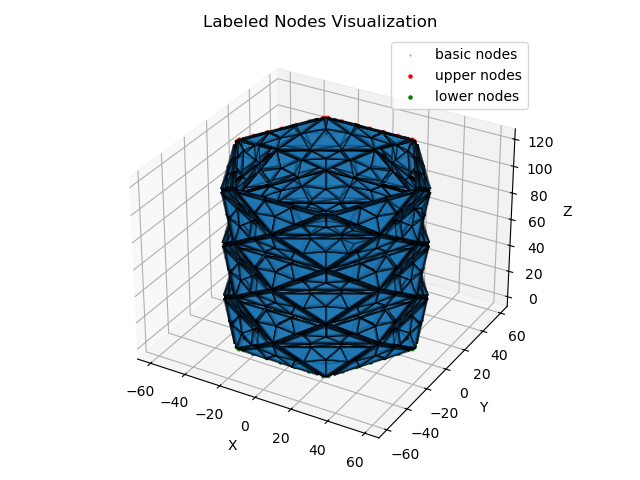

In [3]:
# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

if len(basic_coords) > 0:
    ax.scatter(basic_coords[:, 0], basic_coords[:, 1], basic_coords[:, 2], c='blue',s = 0.05 , label='basic nodes')
if isGroup_face:
    if len(upper_coords) > 0:
        ax.scatter(upper_coords[:, 0], upper_coords[:, 1], upper_coords[:,2], c='red',s = 5 , label='upper nodes')
    if len(lower_coords) > 0:
        ax.scatter( lower_coords[:,0], lower_coords[:,1], lower_coords[:,2], c='green', s = 5 , label='lower nodes')

if plot_faces:
    if is_solid:
        faces = regroup_faces_C3D10(elements, node_coords)
    elif len(elements[0]) == 8:
        faces = regroup_faces_S8R(elements, node_coords)
    else:
        faces = regroup_faces_CPS6(elements, node_coords)
    poly = Poly3DCollection(faces, alpha=0.3, edgecolor='k')
    ax.add_collection3d(poly)

def set_axes_equal(ax):
    """Set equal scaling for all three axes of a 3D plot."""
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    plot_radius = 0.5 * max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

ax.set_title("Labeled Nodes Visualization")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()

set_axes_equal(ax)
plt.tight_layout()
plt.show()

We are analysing the effect of displacement on the face of the object. Therfore we take all the previous nodes associater with labeled faces and we relabeled them as a support set and a displacment set. 

In [66]:
print(len(upper_nset))

1186


In [4]:
with open("upper.nam", "w") as file:
    file.write('**Nodes corresponding to the top surface\n')
    file.write('*NSET, NSET=Nupper\n')
    for node in upper_nset:
        file.write(f'    {node}\n')

with open("lower.nam", "w") as file:
    file.write('**Node corresponding to the bottom surface\n')
    file.write('*NSET, NSET=Nlower\n')
    for node in lower_nset:
        file.write(f'    {node}\n')

In [69]:
print( run_script_name )

run.fbd


In [5]:
os.system(f"cgx -b {run_script_name}")


************************************************************

CalculiX Version 2.22, Copyright(C) 1998-2024 Guido Dhondt
CalculiX comes with ABSOLUTELY NO WARRANTY. This is free
software, and you are welcome to redistribute it under
certain conditions, see gpl.htm

************************************************************

You are using an executable made on Fri May 23 18:17:45 UTC 2025

  The numbers below are estimated upper bounds

  number of:

   nodes:       194013
   elements:       174188
   one-dimensional elements:            0
   two-dimensional elements:            0
   integration points per element:            4
   degrees of freedom per node:            3
   layers per element:            1

   distributed facial loads:            0
   distributed volumetric loads:            0
   concentrated loads:            0
   single point constraints:         8314
   multiple point constraints:            1
   terms in all multiple point constraints:            1
   tie constr

on a Darwin machine, nodename DN51uden.SUNet, release 24.5.0, version Darwin Kernel Version 24.5.0: Tue Apr 22 19:54:26 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T8112, machine arm64 
 The HOME was detected:/Users/hugopenichou
parameters:3 arguments:2
GL_MAX_EVAL_ORDER:30, mesh threads:1
 /Users/hugopenichou/.cgx opened

 reading file
 done 

 run.fbd opened

 reading file
 # solve
 # read results
 file:Living_hinge_1_nl_el.frd opened
 reading frd format
 MODEL NAME:  record:    1UUSER                                                              
record:    1UDATE              31.july.2025                                    
record:    1UTIME              02:16:05                                        
record:    1UHOST                                                              
record:    1UPGM               CalculiX                                        
record:    1UVERSION           Version 2.22                             
record:    1UCOMPILETIME       Mon Aug  5 19:15:2

0

In [63]:
os.system(f"cgx -b res_only.fbd")

on a Darwin machine, nodename Mac.attlocal.net, release 24.5.0, version Darwin Kernel Version 24.5.0: Tue Apr 22 19:54:26 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T8112, machine arm64 
 The HOME was detected:/Users/hugopenichou
parameters:3 arguments:2
GL_MAX_EVAL_ORDER:30, mesh threads:1
 /Users/hugopenichou/.cgx opened

 reading file
 done 

 res_only.fbd opened

 reading file
 # read results
 file:Living_hinge_1_nl_el.frd opened
 reading frd format
 MODEL NAME:  record:    1UUSER                                                              
record:    1UDATE              28.july.2025                                    
record:    1UTIME              00:22:01                                        
record:    1UHOST                                                              
record:    1UPGM               CalculiX                                        
record:    1UVERSION           Version 2.22                             
record:    1UCOMPILETIME       Mon Aug  5 19:15:25 

0

on a Darwin machine, nodename Mac.attlocal.net, release 24.5.0, version Darwin Kernel Version 24.5.0: Tue Apr 22 19:54:26 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T8112, machine arm64 
 The HOME was detected:/Users/hugopenichou
parameters:3 arguments:2
GL_MAX_EVAL_ORDER:30, mesh threads:1
 /Users/hugopenichou/.cgx opened

 reading file
 done 

 Living_hinge_1.fbd opened

 reading file
 # sys gmsh part.step -clcurv -3 -o gmsh.inp -order 2
******************************************************************************
*  read ccx input                                   4.4.2002 wi              *
*                                                                            *
*                                                                            *
* -only free-format is supported. fixed format might cause a prg-crash.      *
*                                                                            *
*                                                                            *

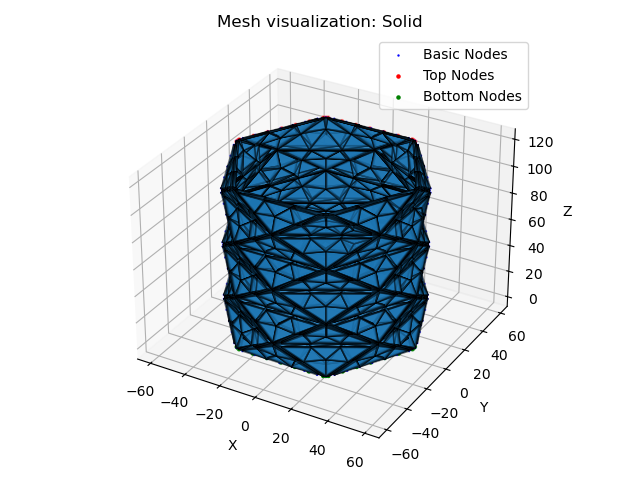

In [4]:
import os
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# =======================
# --- CONFIGURATION ---
# =======================
is_solid = True

part_name = "origami_living_hinge.step" if is_solid else "origami_shell.step"
meshing_script_name = "Living_hinge_1.geo" if is_solid else "Living_hinge_1_shell2.geo"
cgx_script_name = "Living_hinge_1.fbd" if is_solid else "Living_hinge_1_shell.fbd"
meshing_accuracy = 1000

plot_faces = True
plot_nodes = True
displacement_magnitude = -0.2e-1  # Example, used for labeling or quiver if desired

# =======================
# --- FUNCTIONS ---
# =======================

def modify_geo_file(geo_file, part_name, char_length):
    """Update the GEO file to point to the correct STEP and mesh size."""
    with open(geo_file, "r") as file:
        lines = file.readlines()
    with open(geo_file, "w") as file:
        for line in lines:
            if line.strip().startswith("Merge"):
                file.write(f'Merge "{part_name}";\n')
            elif line.strip().startswith("Mesh.CharacteristicLengthMax"):
                file.write(f"Mesh.CharacteristicLengthMax = {char_length};\n")
            else:
                file.write(line)

def parse_msh_file(msh_file, is_solid=True):
    """Parse CalculiX .msh file to extract node coordinates and element connectivity."""
    node_coords = {}
    elements = []

    with open(msh_file, "r") as file:
        in_node_section = False
        in_element_section = False
        for line in file:
            if line.startswith("*NODE"):
                in_node_section = True
                in_element_section = False
                continue
            if line.startswith("*ELEMENT"):
                in_node_section = False
                in_element_section = True
                continue
            if in_node_section:
                parts = line.strip().split(",")
                if len(parts) >= 4:
                    node_id = int(parts[0])
                    node_coords[node_id] = tuple(map(float, parts[1:4]))
            elif in_element_section and not line.startswith("*"):
                node_ids = [int(p) for p in line.split(",")[1:]]
                if is_solid and len(node_ids) == 10:
                    elements.append(node_ids)
                elif not is_solid and len(node_ids) in [6, 8]:
                    elements.append(node_ids)
    return node_coords, elements

def regroup_faces(elements, node_coords, elem_type):
    """Build triangular or quadrilateral faces depending on the element type."""
    faces = []
    for elem in elements:
        try:
            if elem_type == "C3D10":  # 10-node tetra
                n1, n2, n3, n4 = elem[:4]
                faces.extend([
                    [node_coords[n1], node_coords[n2], node_coords[n3]],
                    [node_coords[n1], node_coords[n2], node_coords[n4]],
                    [node_coords[n1], node_coords[n3], node_coords[n4]],
                    [node_coords[n2], node_coords[n3], node_coords[n4]]
                ])
            elif elem_type == "CPS6":  # 6-node triangle shell
                faces.append([node_coords[n] for n in elem[:3]])
            elif elem_type == "S8R":  # 8-node quad shell
                faces.append([node_coords[n] for n in elem[:4]])
        except KeyError as e:
            print(f"Warning: Node ID {e} not found.")
    return faces

def group_faces_by_extremes(node_coords, axis=2, tol=5e-6):
    """Identify top and bottom node groups along a given axis (default Z)."""
    coords = np.array(list(node_coords.values()))
    max_val, min_val = coords[:, axis].max(), coords[:, axis].min()

    group_top = {k:v for k,v in node_coords.items() if abs(v[axis]-max_val)<tol}
    group_bottom = {k:v for k,v in node_coords.items() if abs(v[axis]-min_val)<tol}

    return group_top, group_bottom

def set_axes_equal(ax):
    """Set equal scaling for all three axes of a 3D plot."""
    x_limits, y_limits, z_limits = ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()
    ranges = [abs(lim[1]-lim[0]) for lim in (x_limits, y_limits, z_limits)]
    centers = [np.mean(lim) for lim in (x_limits, y_limits, z_limits)]
    radius = 0.5*max(ranges)
    ax.set_xlim3d([centers[0]-radius, centers[0]+radius])
    ax.set_ylim3d([centers[1]-radius, centers[1]+radius])
    ax.set_zlim3d([centers[2]-radius, centers[2]+radius])

# =======================
# --- MAIN EXECUTION ---
# =======================

# Step 1: Modify GEO and run CGX
modify_geo_file(meshing_script_name, part_name, meshing_accuracy)
os.environ['OMP_NUM_THREADS'] = str(multiprocessing.cpu_count())
os.system(f"cgx -b {cgx_script_name}")

# Step 2: Parse mesh
node_coords, elements = parse_msh_file("all.msh", is_solid=is_solid)
group_top, group_bottom = group_faces_by_extremes(node_coords)

# Step 3: Prepare 3D Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot nodes
basic_nodes = np.array([v for k,v in node_coords.items() if k not in group_top and k not in group_bottom])
top_nodes = np.array(list(group_top.values()))
bottom_nodes = np.array(list(group_bottom.values()))

if plot_nodes and len(basic_nodes)>0:
    ax.scatter(basic_nodes[:,0], basic_nodes[:,1], basic_nodes[:,2], c='blue', s=0.5, label='Basic Nodes')
if len(top_nodes)>0:
    ax.scatter(top_nodes[:,0], top_nodes[:,1], top_nodes[:,2], c='red', s=5, label='Top Nodes')
if len(bottom_nodes)>0:
    ax.scatter(bottom_nodes[:,0], bottom_nodes[:,1], bottom_nodes[:,2], c='green', s=5, label='Bottom Nodes')

# Plot faces
if plot_faces:
    elem_type = "C3D10" if is_solid else ("S8R" if len(elements[0])==8 else "CPS6")
    faces = regroup_faces(elements, node_coords, elem_type)
    poly = Poly3DCollection(faces, alpha=0.3, edgecolor='k')
    ax.add_collection3d(poly)

ax.set_title(f"Mesh visualization: {'Solid' if is_solid else 'Shell'}")
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
ax.legend()
set_axes_equal(ax)
plt.tight_layout()
plt.show()

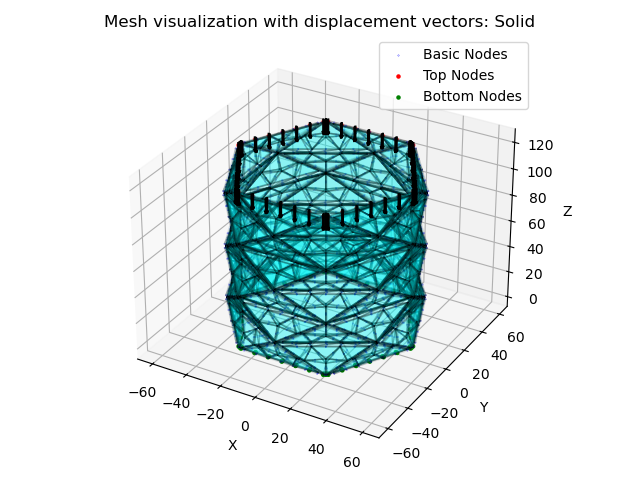

In [12]:
# =======================
# --- PLOTTING ---
# =======================

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

displacement_magnitude = -1 ; 

# Scatter plot nodes
basic_nodes = np.array([v for k,v in node_coords.items() if k not in group_top and k not in group_bottom])
top_nodes = np.array(list(group_top.values()))
bottom_nodes = np.array(list(group_bottom.values()))

if plot_nodes and len(basic_nodes)>0:
    ax.scatter(basic_nodes[:,0], basic_nodes[:,1], basic_nodes[:,2], c='blue', s=0.05, label='Basic Nodes')
if len(top_nodes)>0:
    ax.scatter(top_nodes[:,0], top_nodes[:,1], top_nodes[:,2], c='red', s=5, label='Top Nodes')
if len(bottom_nodes)>0:
    ax.scatter(bottom_nodes[:,0], bottom_nodes[:,1], bottom_nodes[:,2], c='green', s=5, label='Bottom Nodes')

# Plot faces (nearly transparent)
if plot_faces:
    elem_type = "C3D10" if is_solid else ("S8R" if len(elements[0])==8 else "CPS6")
    faces = regroup_faces(elements, node_coords, elem_type)
    poly = Poly3DCollection(faces, alpha=0.05, edgecolor='k', facecolor='cyan')
    ax.add_collection3d(poly)



# Compute Z-span for scaling the arrow length
all_nodes = np.array(list(node_coords.values()))
z_span = all_nodes[:, 2].max() - all_nodes[:, 2].min()
arrow_length = 0.1 * z_span  # 10% of total Z length

# Small offset above top nodes (e.g., 20% of arrow length)
offset_above = 0.2 * arrow_length

if len(top_nodes) > 0:
    # Start points slightly above the top nodes
    start_points = top_nodes.copy()
    start_points[:, 2] += offset_above

    # Arrow points downward to the node
    U = np.zeros(len(top_nodes))                     # X component
    V = np.zeros(len(top_nodes))                     # Y component
    W = np.full(len(top_nodes), -arrow_length)       # Z component negative (downward)

    ax.quiver(
        start_points[:, 0], start_points[:, 1], start_points[:, 2],  # arrow starts above the node
        U, V, W,  # vector components
        color='black', length=1.0, normalize=False,
        arrow_length_ratio=0.2
    )

# Formatting
ax.set_title(f"Mesh visualization with displacement vectors: {'Solid' if is_solid else 'Shell'}")
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
ax.legend()
set_axes_equal(ax)
plt.tight_layout()
plt.show()